/home/ris/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-29 22:39:06,965] A new study created in memory with name: no-name-28960d53-d916-47ac-a597-d0bda393ad25


Device = cuda


[I 2025-04-29 22:39:23,219] Trial 0 finished with value: -0.4313949057922177 and parameters: {'n_layers': 5, 'width': 87, 'dropout_rate': 0.2832960045674662, 'weights': '0.00_0.00_1.00'}. Best is trial 0 with value: -0.4313949057922177.
[I 2025-04-29 22:39:39,282] Trial 1 finished with value: -0.2857355287902877 and parameters: {'n_layers': 5, 'width': 121, 'dropout_rate': 0.2613095039338082, 'weights': '0.00_0.00_1.00'}. Best is trial 1 with value: -0.2857355287902877.
[I 2025-04-29 22:39:54,651] Trial 2 finished with value: -0.4904482847476432 and parameters: {'n_layers': 2, 'width': 115, 'dropout_rate': 0.007100403620615314, 'weights': '0.00_0.00_1.00'}. Best is trial 1 with value: -0.2857355287902877.
[I 2025-04-29 22:40:10,066] Trial 3 finished with value: -0.3628548049496484 and parameters: {'n_layers': 3, 'width': 92, 'dropout_rate': 0.08267265390450244, 'weights': '0.00_0.00_1.00'}. Best is trial 1 with value: -0.2857355287902877.
[I 2025-04-29 22:40:25,603] Trial 4 finished wi

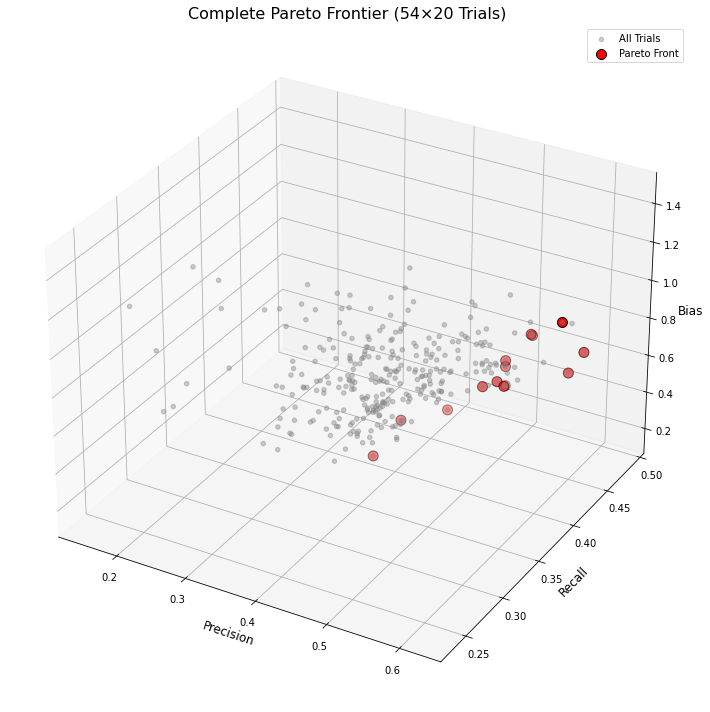

In [1]:
import os
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import gc
import sys

# Basic settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device = {device}")
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = ImageFolder(root="2/Training", transform=transform)
test_dataset = ImageFolder(root="2/Testing", transform=transform)

# Split training into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)

# Generate all weight combinations as strings
weight_combinations = []
steps = [0.0, 0.25, 0.5, 0.75, 1.0]

for w1 in steps:
    for w2 in steps:
        for w3 in steps:
            if abs(w1 + w2 + w3 - 1.0) < 1e-9:
                weight_str = f"{w1:.2f}_{w2:.2f}_{w3:.2f}"
                weight_combinations.append(weight_str)

# Memory-efficient Model Definition
class CustomResNet(nn.Module):
    def __init__(self, n_layers, width, dropout_rate, num_classes):
        super(CustomResNet, self).__init__()
        self.features = self._make_layers(n_layers, width, dropout_rate)
        self.classifier = nn.Linear(width, num_classes)
    
    def _make_layers(self, n_layers, width, dropout_rate):
        layers = []
        in_channels = 3
        
        layers.extend([
            nn.Conv2d(in_channels, width//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(width//4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        ])
        in_channels = width//4
        
        for i in range(n_layers):
            layers.extend([
                nn.Conv2d(in_channels, width, kernel_size=3, padding=1),
                nn.BatchNorm2d(width),
                nn.ReLU(inplace=True),
            ])
            
            if (i + 1) % 2 == 0:
                layers.append(nn.MaxPool2d(2, 2))
                
            layers.append(nn.Dropout2d(p=dropout_rate))
            in_channels = width
        
        layers.append(nn.AdaptiveAvgPool2d((1, 1)))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Metrics
def calculate_metrics(y_true, y_pred, num_classes):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    label_counts = cm.sum(axis=0)
    bias = np.std(label_counts) / (np.mean(label_counts) + 1e-6)
    return precision, recall, bias

def cleanup():
    torch.cuda.empty_cache()
    gc.collect()

# Enhanced objective function with better error handling
def objective(trial):
    model = None
    optimizer = None
    try:
        # Sample hyperparameters
        n_layers = trial.suggest_int('n_layers', 2, 6)
        width = trial.suggest_int('width', 32, 128)
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)
        
        # Get weight combination
        weight_str = trial.suggest_categorical('weights', weight_combinations)
        w1, w2, w3 = map(float, weight_str.split('_'))
        
        model = CustomResNet(n_layers, width, dropout_rate, num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        best_val_score = -np.inf
        patience = 2
        no_improve = 0
        
        for epoch in range(3):
            model.train()
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            # Validation
            model.eval()
            val_preds, val_labels = [], []
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    preds = outputs.argmax(dim=1)
                    val_preds.append(preds.cpu().numpy())
                    val_labels.append(targets.cpu().numpy())
                    
            val_preds = np.concatenate(val_preds)
            val_labels = np.concatenate(val_labels)
            precision, recall, bias = calculate_metrics(val_labels, val_preds, num_classes)
            current_score = w1*precision + w2*recall - w3*bias
            
            if current_score > best_val_score:
                best_val_score = current_score
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break
        
        return best_val_score
    
    except RuntimeError as e:
        if 'CUDA out of memory' in str(e):
            print(f"Pruning trial due to OOM: {str(e)[:200]}...")
            raise optuna.exceptions.TrialPruned()
        print(f"Runtime error: {str(e)}")
        raise optuna.exceptions.TrialPruned()
    
    except KeyboardInterrupt:
        print("\nTrial interrupted by user. Cleaning up resources...")
        raise optuna.exceptions.TrialPruned()
    
    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        raise optuna.exceptions.TrialPruned()
    
    finally:
        if model is not None:
            del model
        if optimizer is not None:
            del optimizer
        cleanup()

# Main optimization process
def main_optimization():
    try:
        # Create study and enqueue all trials
        study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())

        # Enqueue 20 trials for each weight combination
        for weight_str in weight_combinations:
            for _ in range(20):
                study.enqueue_trial({'weights': weight_str})

        # Run all trials (54 combinations * 20 trials = 1080 trials)
        study.optimize(objective, n_trials=len(weight_combinations)*20, gc_after_trial=True)

        # Process and save results
        process_and_save_results(study.trials)

    except KeyboardInterrupt:
        print("\nOptimization process interrupted. Finalizing results...")
        process_and_save_results(study.trials if 'study' in locals() else [])
        sys.exit(0)

def process_and_save_results(trials):
    results = []
    for trial in trials:
        if trial.state == optuna.trial.TrialState.COMPLETE and trial.value is not None:
            params = trial.params
            weight_str = params['weights']
            w1, w2, w3 = map(float, weight_str.split('_'))
            
            model = CustomResNet(params['n_layers'], params['width'], params['dropout_rate'], num_classes).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            
            try:
                # Train final model
                for epoch in range(5):
                    model.train()
                    for inputs, targets in train_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                        loss.backward()
                        optimizer.step()
                
                # Evaluate
                model.eval()
                all_preds, all_labels = [], []
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        outputs = model(inputs)
                        preds = outputs.argmax(dim=1)
                        all_preds.append(preds.cpu().numpy())
                        all_labels.append(targets.cpu().numpy())
                
                all_preds = np.concatenate(all_preds)
                all_labels = np.concatenate(all_labels)
                precision, recall, bias = calculate_metrics(all_labels, all_preds, num_classes)
                
                results.append((
                    params['n_layers'],
                    params['width'],
                    params['dropout_rate'],
                    w1,
                    w2,
                    w3,
                    precision,
                    recall,
                    bias
                ))
                
            finally:
                del model, optimizer
                cleanup()

    if results:
        with open('full_pareto_results.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['n_layers', 'width', 'dropout', 'w1', 'w2', 'w3', 'precision', 'recall', 'bias'])
            writer.writerows(results)

        # Pareto frontier calculation
        def get_pareto_frontier(results):
            frontier = []
            for candidate in results:
                dominated = False
                for other in results:
                    if (other[6] >= candidate[6] and  # precision
                        other[7] >= candidate[7] and  # recall
                        other[8] <= candidate[8] and  # bias
                        (other[6] > candidate[6] or 
                         other[7] > candidate[7] or 
                         other[8] < candidate[8])):
                        dominated = True
                        break
                if not dominated:
                    frontier.append(candidate)
            return sorted(frontier, key=lambda x: (-x[6], -x[7], x[8]))

        pareto_front = get_pareto_frontier(results)
        
        with open('full_pareto_front.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['n_layers', 'width', 'dropout', 'w1', 'w2', 'w3', 'precision', 'recall', 'bias'])
            writer.writerows(pareto_front)

        # Visualization
        if pareto_front:
            fig = plt.figure(figsize=(14, 10))
            ax = fig.add_subplot(111, projection='3d')

            all_prec = [r[6] for r in results]
            all_rec = [r[7] for r in results]
            all_bias = [r[8] for r in results]
            ax.scatter(all_prec, all_rec, all_bias, c='grey', alpha=0.4, label='All Trials')

            front_prec = [r[6] for r in pareto_front]
            front_rec = [r[7] for r in pareto_front]
            front_bias = [r[8] for r in pareto_front]
            ax.scatter(front_prec, front_rec, front_bias, c='red', s=100, 
                      edgecolors='black', label='Pareto Front')

            ax.set_xlabel('Precision', fontsize=12)
            ax.set_ylabel('Recall', fontsize=12)
            ax.set_zlabel('Bias', fontsize=12)
            plt.title('Complete Pareto Frontier (54×20 Trials)', fontsize=16)
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("No Pareto frontier points found")
    else:
        print("No successful trials completed")

if __name__ == "__main__":
    main_optimization()